# Demonstrating the effect of low mesh resolution on line profiles

This notebook demonstrates how using a low-resolution mesh to model a rotating star's surface can affect the accuracy of simulated spectral line profiles. By comparing results from models with different numbers of surface elements (mesh resolutions), we can visualize and quantify the impact of mesh resolution on the fidelity of the computed spectra.


In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.spectrum import simulate_observed_flux
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

Let's create models with approximate resolutions and use default parameters.

In [2]:
tp = TransformerPayne.download()

models = {}

models[1000] = IcosphereModel.construct(1000, 1.0, 1.0, tp.to_parameters(), tp.stellar_parameter_names)
models[5000] = IcosphereModel.construct(5000, 1.0, 1.0, tp.to_parameters(), tp.stellar_parameter_names)
models[20000] = IcosphereModel.construct(20000, 1.0, 1.0, tp.to_parameters(), tp.stellar_parameter_names)

Let's evaluate the models at one single timesteps

In [3]:
from collections import defaultdict

rs = [1000, 5000, 20000]
vs = [0, 20, 50, 100]
models_with_vs = defaultdict(dict)

for r in rs:
    for v in vs:
        models_with_vs[r][v] = add_rotation(models[r], v)
        
evaluated_models = defaultdict(dict)
for r in rs:
    for v in vs:
        evaluated_models[r][v] = evaluate_rotation(models_with_vs[r][v], 1.)

Let's synthesize the spectrum around a Fe I line:

In [4]:
import os
import pickle
VACUUM_REFRACTIVE_INDEX = 1.000277
CENTER_LINE = 5049.82*VACUUM_REFRACTIVE_INDEX
MARGIN = 2.

vws = jnp.linspace(CENTER_LINE - MARGIN, CENTER_LINE + MARGIN, 200)
line_fluxes = defaultdict(dict)

if not os.path.exists("line_fluxes.pkl"):

    for r in tqdm(rs, desc="Resolution"):
        for v in tqdm(vs, desc="Velocity", leave=False):
            line_fluxes[r][v] = simulate_observed_flux(tp.intensity, evaluated_models[r][v], jnp.log10(vws))
    with open("line_fluxes.pkl", "wb") as f:
        pickle.dump(line_fluxes, f)
else:
    line_fluxes = pickle.load(open("line_fluxes.pkl", "rb"))

In [5]:
# Calculate the spectral resolution R = lambda / delta_lambda, where delta_lambda is the wavelength step
# We'll use the center wavelength and the step between vws points

center_wavelength = (vws[0] + vws[-1]) / 2
delta_lambda = vws[1] - vws[0]
spectral_resolution = center_wavelength / delta_lambda

print(f"Spectral resolution (R) = {spectral_resolution:.0f}")

Spectral resolution (R) = 252315


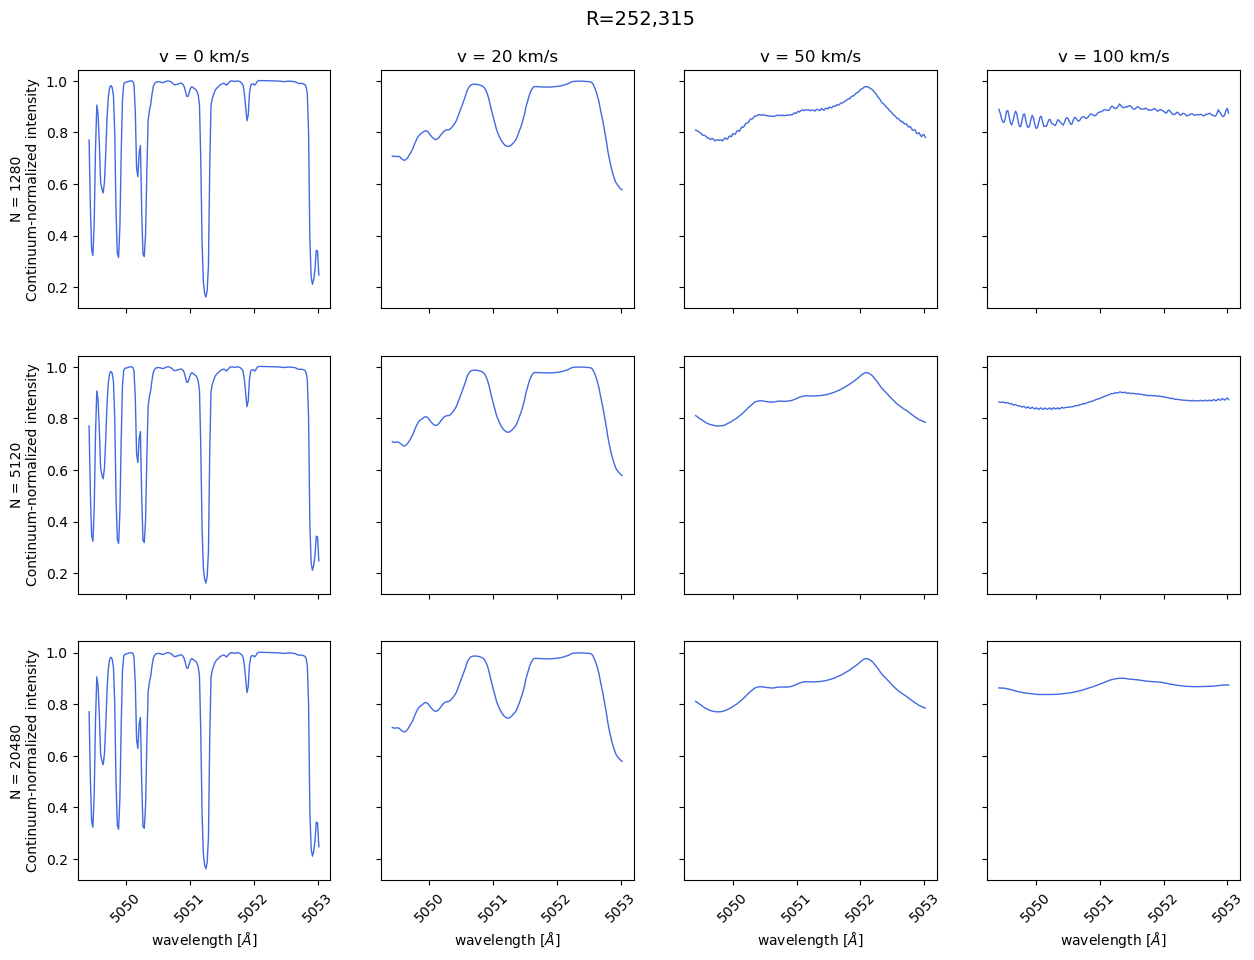

In [6]:
import matplotlib as mpl
import cmasher as cmr

# Create a figure with subplots for each resolution and velocity
fig, axs = plt.subplots(nrows=len(rs), ncols=len(vs), figsize=(15, 10), 
                        sharex=True, sharey=True, squeeze=False)

# Loop through each resolution and velocity
for i, r in enumerate(rs):
    for j, v in enumerate(vs):
        ax = axs[i, j]
        
        # Get the spectra for this resolution and velocity
        spectra = line_fluxes[r][v]
        n_lines = len(spectra)
        
        # Create colormap
        cmap = cmr.bubblegum
        colors = cmap(np.linspace(0, 1, n_lines))
        
        # Plot each spectrum with a different color
        ax.plot(vws[10:-10], line_fluxes[r][v][10:-10, 0]/line_fluxes[r][v][10:-10, 1], color='royalblue', linewidth=1.)
        
        # Add labels to the first row and column
        if i == 0:
            ax.set_title(f'v = {v} km/s')
        if j == 0:
            ax.set_ylabel(f'N = {len(models[r].areas)}\nContinuum-normalized intensity')
        
        # Only add x-label to the bottom row
        if i == len(rs) - 1:
            ax.set_xlabel(r'wavelength [$\AA$]')
            ax.tick_params(axis='x', rotation=45)
            
# Adjust layout
fig.suptitle('R=252,315', fontsize=14)
fig.subplots_adjust(top=0.92)  # Reduce top margin (default is ~0.94)

#lt.tight_layout(rect=[0, 0, 0.9, 1])#

In [7]:
fig.savefig('mesh_resolution_effects.png', dpi=300)

In [8]:
# Measure the noise level as a percentage with the highest resolution spectrum as the reference

noise_values = defaultdict(dict)
for r in rs[:2]:
    for v in vs:
        noise_level = (line_fluxes[r][v][10:-10, 0] / line_fluxes[r][v][10:-10, 1]) / (line_fluxes[20000][v][10:-10, 0] / line_fluxes[20000][v][10:-10, 1])
        noise_values[r][v] = np.max(noise_level).item()


for r in rs[:2]:
    for v in vs:
        print(f'Resolution={r}, v={v}: {(noise_values[r][v]-1.)*100}%')

Resolution=1000, v=0: 0.08196830749511719%
Resolution=1000, v=20: 0.16672611236572266%
Resolution=1000, v=50: 0.6586670875549316%
Resolution=1000, v=100: 3.616940975189209%
Resolution=5000, v=0: 0.016307830810546875%
Resolution=5000, v=20: 0.12971162796020508%
Resolution=5000, v=50: 0.09428262710571289%
Resolution=5000, v=100: 0.45293569564819336%


In [9]:
from spice.spectrum.utils import apply_spectral_resolution

resolution = 70000

line_fluxes_medium_res = defaultdict(dict)

for r in rs:
    for v in vs:
        line_fluxes_medium_res[r][v] = apply_spectral_resolution(jnp.log10(jnp.array(vws)), jnp.array(line_fluxes[r][v][:, 0]/line_fluxes[r][v][:, 1]), resolution)

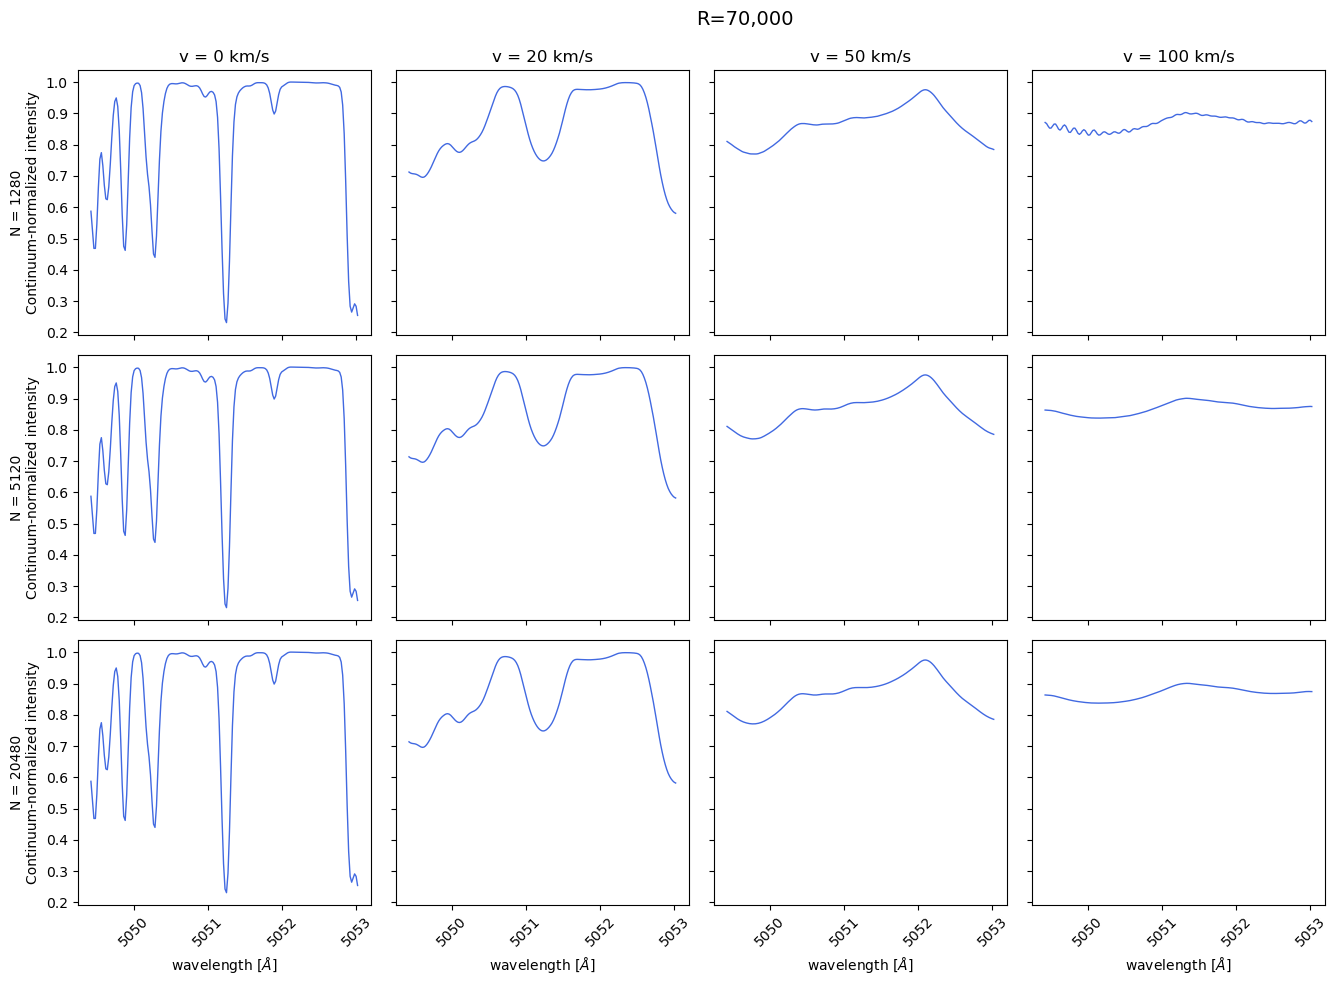

In [10]:
import matplotlib as mpl
import cmasher as cmr

# Create a figure with subplots for each resolution and velocity
fig, axs = plt.subplots(nrows=len(rs), ncols=len(vs), figsize=(15, 10), 
                        sharex=True, sharey=True, squeeze=False)

# Loop through each resolution and velocity
for i, r in enumerate(rs):
    for j, v in enumerate(vs):
        ax = axs[i, j]
        
        # Get the spectra for this resolution and velocity
        spectra = line_fluxes[r][v]
        n_lines = len(spectra)
        
        # Create colormap
        cmap = cmr.bubblegum
        colors = cmap(np.linspace(0, 1, n_lines))
        
        # Plot each spectrum with a different color
        ax.plot(vws[10:-10], line_fluxes_medium_res[r][v][10:-10], color='royalblue', linewidth=1.)
        
        # Add labels to the first row and column
        if i == 0:
            ax.set_title(f'v = {v} km/s')
        if j == 0:
            ax.set_ylabel(f'N = {len(models[r].areas)}\nContinuum-normalized intensity')
        
        # Only add x-label to the bottom row
        if i == len(rs) - 1:
            ax.set_xlabel(r'wavelength [$\AA$]')
            ax.tick_params(axis='x', rotation=45)
            
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
fig.suptitle('R=70,000', fontsize=14)
fig.subplots_adjust(top=0.92)  # Reduce top margin (default is ~0.94)

In [11]:
fig.savefig('mesh_resolution_effects_medium_res.png', dpi=300)

In [12]:
medium_res_noise_values = defaultdict(dict)
for r in rs[:2]:
    for v in vs:
        noise_level = line_fluxes_medium_res[r][v][10:-10]/ line_fluxes_medium_res[20000][v][10:-10]
        medium_res_noise_values[r][v] = np.max(noise_level).item()


for r in rs[:2]:
    for v in vs:
        print(f'Resolution={r}, v={v}: {(medium_res_noise_values[r][v]-1.)*100}%')
resolution = 30000

line_fluxes_low_res = defaultdict(dict)

for r in rs:
    for v in vs:
        line_fluxes_low_res[r][v] = apply_spectral_resolution(jnp.log10(jnp.array(vws)), jnp.array(line_fluxes[r][v][:, 0]/line_fluxes[r][v][:, 1]), resolution)

Resolution=1000, v=0: 0.0466465950012207%
Resolution=1000, v=20: 0.0729680061340332%
Resolution=1000, v=50: 0.0872492790222168%
Resolution=1000, v=100: 1.3970494270324707%
Resolution=5000, v=0: 0.009322166442871094%
Resolution=5000, v=20: 0.057828426361083984%
Resolution=5000, v=50: 0.049114227294921875%
Resolution=5000, v=100: 0.03631114959716797%


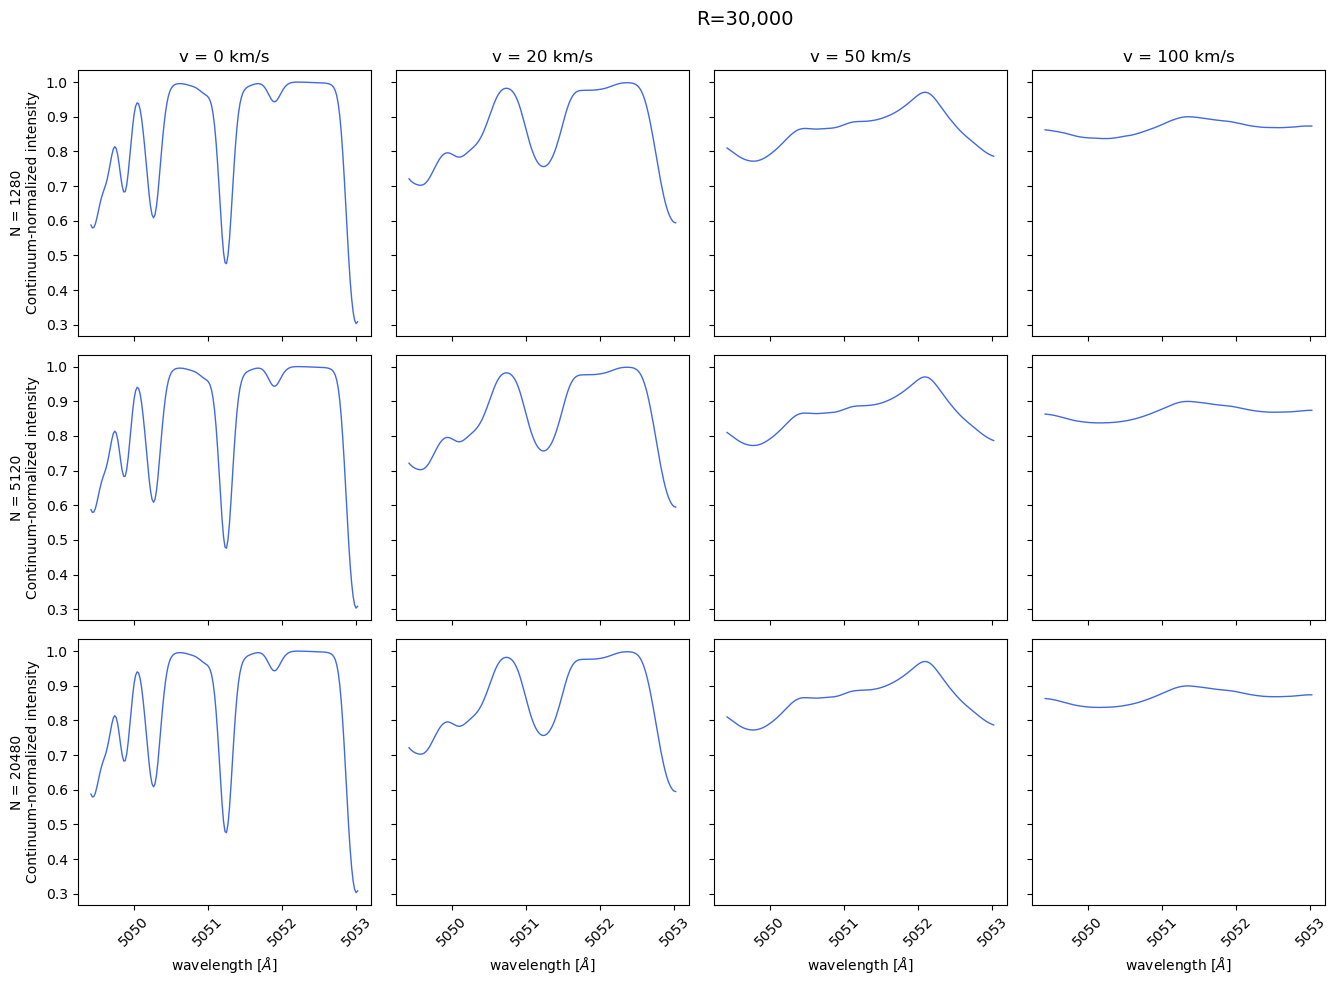

In [13]:
import matplotlib as mpl
import cmasher as cmr

# Create a figure with subplots for each resolution and velocity
fig, axs = plt.subplots(nrows=len(rs), ncols=len(vs), figsize=(15, 10), 
                        sharex=True, sharey=True, squeeze=False)

# Loop through each resolution and velocity
for i, r in enumerate(rs):
    for j, v in enumerate(vs):
        ax = axs[i, j]
        
        # Get the spectra for this resolution and velocity
        spectra = line_fluxes[r][v]
        n_lines = len(spectra)
        
        # Create colormap
        cmap = cmr.bubblegum
        colors = cmap(np.linspace(0, 1, n_lines))
        
        # Plot each spectrum with a different color
        ax.plot(vws[10:-10], line_fluxes_low_res[r][v][10:-10], color='royalblue', linewidth=1.)
        
        # Add labels to the first row and column
        if i == 0:
            ax.set_title(f'v = {v} km/s')
        if j == 0:
            ax.set_ylabel(f'N = {len(models[r].areas)}\nContinuum-normalized intensity')
        
        # Only add x-label to the bottom row
        if i == len(rs) - 1:
            ax.set_xlabel(r'wavelength [$\AA$]')
            ax.tick_params(axis='x', rotation=45)
            
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
fig.suptitle('R=30,000', fontsize=14)
fig.subplots_adjust(top=0.92)  # Reduce top margin (default is ~0.94)

In [14]:
fig.savefig('mesh_resolution_effects_low_res.png', dpi=300)

In [15]:
low_res_noise_values = defaultdict(dict)
for r in rs[:2]:
    for v in vs:
        noise_level = line_fluxes_low_res[r][v][10:-10]/ line_fluxes_low_res[20000][v][10:-10]
        low_res_noise_values[r][v] = np.max(noise_level).item()


for r in rs[:2]:
    for v in vs:
        print(f'Resolution={r}, v={v}: {(low_res_noise_values[r][v]-1.)*100}%')

Resolution=1000, v=0: 0.011241436004638672%
Resolution=1000, v=20: 0.05158185958862305%
Resolution=1000, v=50: 0.06611347198486328%
Resolution=1000, v=100: 0.16404390335083008%
Resolution=5000, v=0: 0.0022411346435546875%
Resolution=5000, v=20: 0.022494792938232422%
Resolution=5000, v=50: 0.017690658569335938%
Resolution=5000, v=100: 0.023281574249267578%


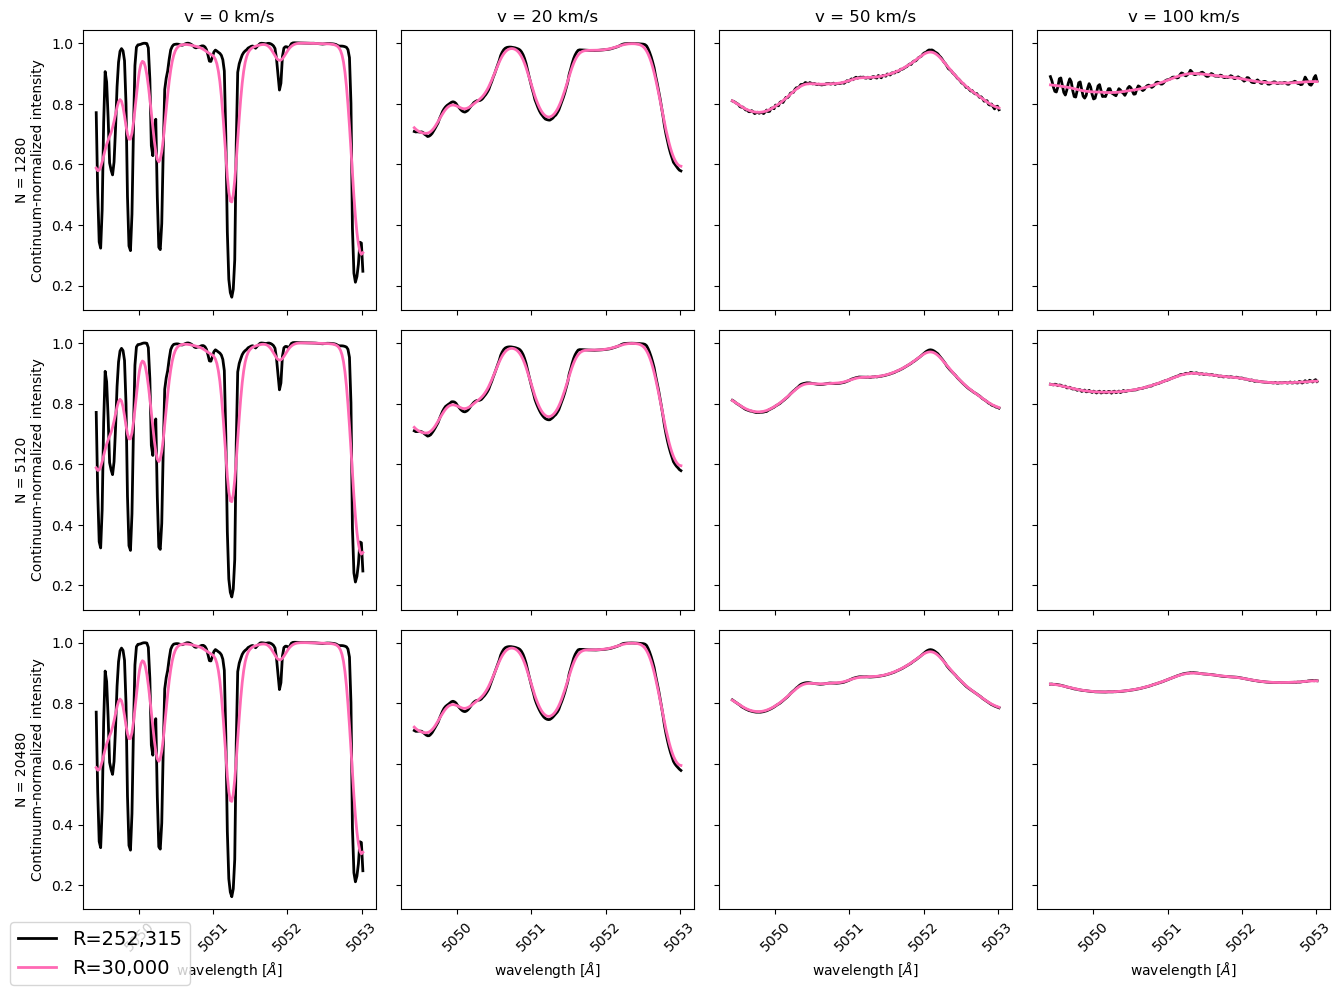

In [16]:
import matplotlib as mpl
import cmasher as cmr

# Create a figure with subplots for each resolution and velocity
fig, axs = plt.subplots(nrows=len(rs), ncols=len(vs), figsize=(15, 10), 
                        sharex=True, sharey=True, squeeze=False)

# Loop through each resolution and velocity
for i, r in enumerate(rs):
    for j, v in enumerate(vs):
        ax = axs[i, j]
        
        # Get the spectra for this resolution and velocity
        spectra = line_fluxes[r][v]
        n_lines = len(spectra)
        
        # Create colormap
        cmap = cmr.bubblegum
        colors = cmap(np.linspace(0, 1, n_lines))
        
        # Plot each spectrum with a different color
        ax.plot(vws[10:-10], line_fluxes[r][v][10:-10, 0]/line_fluxes[r][v][10:-10, 1], color='black', linewidth=2.)
        ax.plot(vws[10:-10], line_fluxes_low_res[r][v][10:-10], color='hotpink', linewidth=2.)
        
        # Add labels to the first row and column
        if i == 0:
            ax.set_title(f'v = {v} km/s')
        if j == 0:
            ax.set_ylabel(f'N = {len(models[r].areas)}\nContinuum-normalized intensity')
        
        # Only add x-label to the bottom row
        if i == len(rs) - 1:
            ax.set_xlabel(r'wavelength [$\AA$]')
            ax.tick_params(axis='x', rotation=45)
            
# Create global legend handles
from matplotlib.lines import Line2D

legend_handles = [
    Line2D([0], [0], color='black', linewidth=2., label='R=252,315'),
    Line2D([0], [0], color='hotpink', linewidth=2., label='R=30,000')
]

# Place the global legend to the right of the subplots
fig.legend(handles=legend_handles, loc='lower left', fontsize=14) #bbox_to_anchor=(0.90, 0.5), frameon=False, fontsize=14)
            
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])

In [17]:
fig.savefig('mesh_resolution_effects_comparison.png', dpi=300)